In [197]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from IPython.display import Audio

sr = 96000
segment_samples = 2048

def gen_sine_WT(frequency, sample_rate):
    length = 12288 * 1/sample_rate
    t_arr = np.arange(0, length, 1/sample_rate) 
    # print ('t_arr length: ', len(t_arr))
    output = np.sin(2 * np.pi * frequency * t_arr)
    # print('output length: ', len(output))
    return output

def sine_gen(amplitude, frequency, phase, duration, sample_rate):
    t_v = np.arange(0, duration, 1/sample_rate) 
    output = amplitude * np.sin(2 * np.pi * frequency * t_v + phase)
    return output

def square_gen(amplitude, frequency, phase, duration, sample_rate, num_harmonics):
    output = np.zeros(duration * sample_rate)
    curr_harmonic = 1
    for i in range(num_harmonics):
        output += sine_gen(1/curr_harmonic, curr_harmonic * frequency, 0, duration, sample_rate)
        curr_harmonic += 2
    return output * amplitude

# def vari_triangle_gen(amplitude, frequency, phase, duration, sample_rate, num_harmonics):


def crossMod(wv_1, wv_2):
    length = wv_1.size
    y = np.zeros(length)
    for i in range(length):
        interpFactor = i / length
        y[i] = (1 - interpFactor) * wv_1[i] + interpFactor * wv_2[i]
    return y

def progressively_decimate(signal):
    npSignal = np.array(signal)
    length = signal.size

    # splitting the signal into four slices, each of which will be decimated by a greater factor
    firstBound = np.floor(length / 4).astype(int)
    secondBound = firstBound * 2
    thirdBound = firstBound * 3

    # generating the new slices and decimating by taking every nth sample, as coded by the third argument
    firstSlice = npSignal[0:firstBound:1]
    secondSlice = npSignal[firstBound:secondBound:2]
    thirdSlice = npSignal[secondBound:thirdBound:3]
    fourthSlice = npSignal[thirdBound:length:4]

    # combining all the slices into a final return array of the progressively decimated signals
    y = np.concatenate((firstSlice, secondSlice, thirdSlice, fourthSlice))

    return y

def bitCrush(signal, new_bit_depth):
    # get new bit depth
    bdepth = 2 ** new_bit_depth
    # use new bit depth to rescale the signal
    scaled_signal = np.interp(signal, (-1, 1), (0, bdepth - 1))
    # Quantize by rounding to nearest integer
    quantized_signal = np.round(scaled_signal)
    # Rescale back to the range -1 to 1
    rescaled_signal = np.interp(quantized_signal, (0, bdepth - 1), (-1, 1))
    
    return rescaled_signal

def finalTransform(w1_freq, w2_freq, bitDepth, squareHarmonics, sr_bool, output_file = 'WT_out.wav'):
    # generate our sine and square waves
    sine1 = sine_gen(1, w1_freq, 0, 2, sr)
    square = square_gen(0.5, w2_freq, 0, 2, sr, squareHarmonics)
    # interpolate smoothly from the initial sine wave to the square wave
    returnTable = crossMod(sine1, square)
    # if the user specifies, perform progressive decimate the signal
    if sr_bool == 1:
        returnTable = progressively_decimate(returnTable)
    # bit crush the signal to the specified bit depth
    returnTable = bitCrush(returnTable, bitDepth)
    max_val = np.max(np.abs(returnTable))
    returnTable = returnTable / max_val
    sf.write(output_file, returnTable, sr)
    return returnTable

finalTransform(440,440, 24,25, 1, 'WT_1.wav')

array([ 5.96200569e-08,  2.88028668e-02,  5.75831376e-02, ...,
       -3.93601540e-01, -3.83546856e-01, -3.60179371e-01])

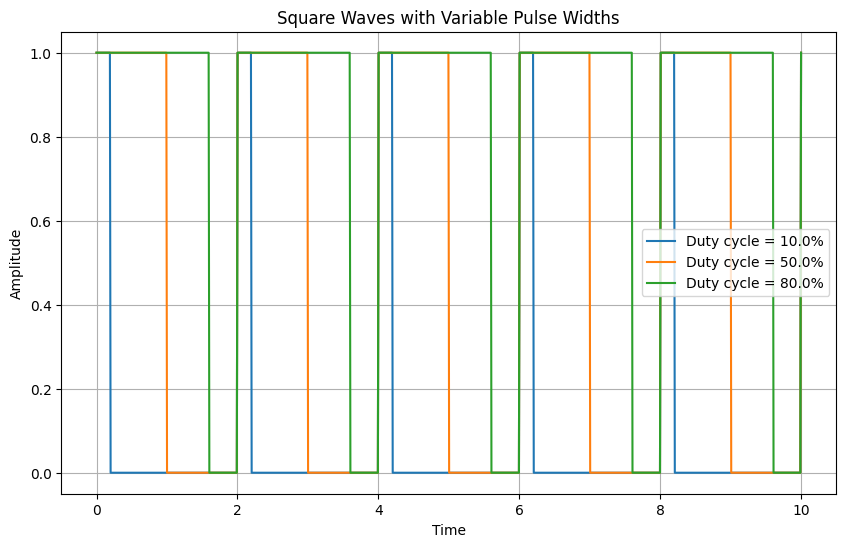

In [198]:
import numpy as np
import matplotlib.pyplot as plt

def square_wave(t, period, duty_cycle, amplitude=1):
    """
    Generate a square wave with variable pulse width.
    
    Args:
    t (np.array): The input time array.
    period (float): The period of the square wave.
    duty_cycle (float): The duty cycle of the square wave (0 to 1).
    amplitude (float): The amplitude of the square wave.
    
    Returns:
    np.array: The amplitude values of the square wave.
    """
    return amplitude * (np.mod(t, period) < duty_cycle * period)

# Example usage
t = np.linspace(0, 10, 1000)  # time from 0 to 10 with 1000 points
duty_cycles = [0.1, 0.5, 0.8]  # different duty cycles

plt.figure(figsize=(10, 6))
for D in duty_cycles:
    y = square_wave(t, period=2, duty_cycle=D)
    plt.plot(t, y, label=f'Duty cycle = {D * 100}%')

plt.title('Square Waves with Variable Pulse Widths')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

In [199]:
sameFreqNoSR = finalTransform(440,440, 24,25, 0, 'sameFreqNoSR.wav')
Audio(sameFreqNoSR, rate = sr)

In [200]:
# def sine_gen(amplitude, frequency, phase, duration, sample_rate):
#     t_v = np.arange(0, duration, 1/sample_rate) 
#     output = amplitude * np.sin(2 * np.pi * frequency * t_v + phase)
#     return output
testWT = gen_sine_WT(190, sr)
testWT2 = gen_sine_WT(440, sr)
t = int(3072 * 1/sr)
print('t: ', 3072 * 1/sr)
# wt3 = square_gen(1, 440, 0, .032, sr, 10)
# wt4 = square_gen(1, 440, 0, t, sr, 25)

comboWT = np.concatenate([testWT, testWT2])
print('testWT length: ', len(testWT))
print('combo length: ', len(comboWT))   
# crossTest = crossMod(testWT, testWT2)
# ct2 = crossMod(wt3, wt4)
# crossCombo = np.concatenate([crossTest, ct2])
# sf.write('crosstest.wav', crossCombo, sr, subtype='FLOAT')
sf.write('combo.wav', comboWT, sr, subtype='FLOAT')
sf.write('new_sine.wav', testWT, sr,subtype='FLOAT')    
Audio(comboWT, rate = sr)

inWav = sf.read('Evolution.wav')
print('inWAV length: ', len(inWav[0]))


t:  0.032
testWT length:  12288
combo length:  24576
inWAV length:  12288


In [201]:
thisLen = 2048 * 1/sr
testSine = sine_gen(1, 440, 0, thisLen, sr)
sf.write('testSine.wav', testWT, sr)
Audio(testSine, rate = sr)


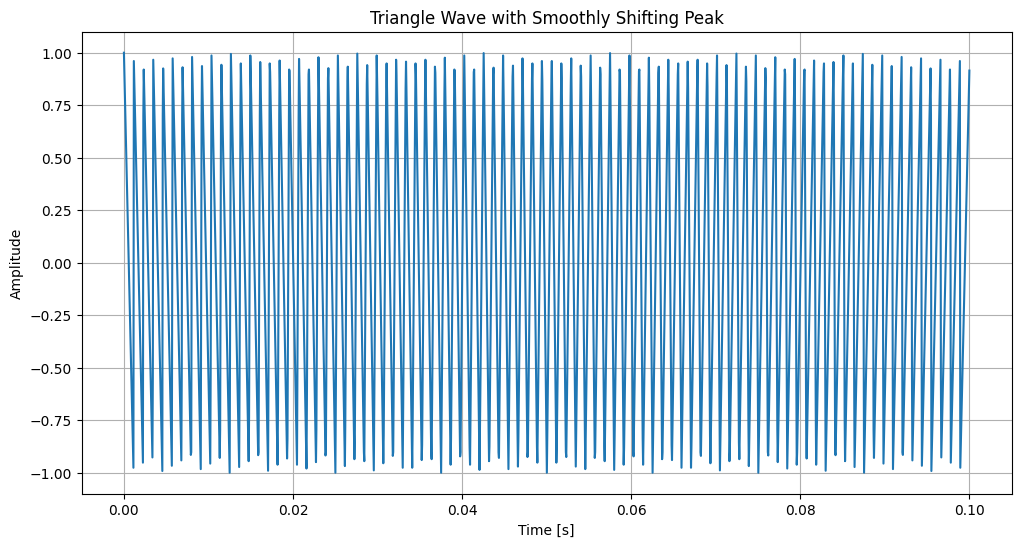

In [204]:
def variable_triangle_gen():
    # since this oscillator will be used for wavetable generation, I do not need to dynamically change frequency, duration, or amplitude, and instead hard coded them below
    frequency = 440
    duration = 0.1
    
    # here I am generating a sequence of time values that scale evenly from 0 to the duration constant I have set, which was optimized for wavetable reading in serum
    # For the length of the t array, I use the globally set segment_samples variable
    # Setting endpoint to false helps ensure full periodicity within the signal
    t = np.linspace(0, duration, segment_samples, endpoint=False)
    
    # Sets the period of the triangle wave, this will allow us to track where within the cycle we are and set up or down slopes accordingly
    period = 1 / frequency
    
    # this generates an array of zeros of the correct length, allowing us to iterate through and set the proper amplitudes for the variable triangle wave
    output = np.zeros(segment_samples)
    for i in range(segment_samples):
        # In order to calculate a value to shift the peak of the triangle wave over the course of the signal, I need a variable to track this progress through the range:
        peak_pos = t[i] / duration
        
        # Time modulo the period to find the position within the period
        t_mod = t[i] % period
        if t_mod < peak_pos * period:
            # Rising edge of the triangle
            output[i] = (t_mod / (peak_pos * period)) * 2 - 1
        else:
            # Falling edge of the triangle
            output[i] = ((period - t_mod) / (period - peak_pos * period)) * 2 - 1
    
    # Scale the waveform by the amplitude
    output *= 1
    
    return output

# Example usage
duration = .1  # in seconds
sample_rate = 44100  # in Hz
frequency = 440  # in Hz, slower frequency to see the shifting peak clearly
amplitude = 1

waveform = variable_triangle_gen()
sf.write('triangle_wave.wav', waveform, sample_rate, subtype='FLOAT')

# Plot the generated waveform
plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0, duration, len(waveform)), waveform)
plt.title("Triangle Wave with Smoothly Shifting Peak")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()